Import necessary packages and load the fully trained model to run on the created contigs and perform clique detection using a poisson distribution on the contigs

In [14]:
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, utils, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
import scipy.stats as sp
from scipy.stats import poisson
import networkx as nx
import numpy as np

In [2]:
os.getcwd()

'/Users/samklauer/GitHub/PawseySummer2024/Full Code'

In [3]:
os.chdir('../')

In [4]:
newmodel = tf.keras.models.load_model(
    './bestmodel.keras', compile=False)

2025-03-10 13:23:52.185668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
new_segs = []
seg = ''
f = open('./metagenome/mockmeta/contigs.fasta', 'r')
for i in f:
    if i[0] == '>':
        if seg != '':
            new_segs.append(seg)
            seg = ''
    else:
        seg += i.strip()
new_segs.append(seg)

In [6]:
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'U':[0, 0, 0, 1], 'N':[0,0,0,0]
    , 'M':[0,0,0,0], 'R':[0,0,0,0], 'W':[0,0,0,0], 'S':[0,0,0,0], 'Y':[0,0,0,0], 'K':[0,0,0,0], 'V':[0,0,0,0], 'H':[0,0,0,0], 'D':[0,0,0,0],
    'B':[0,0,0,0], 'E':[0,0,0,0], 'F':[0,0,0,0], 'I':[0,0,0,0], 'J':[0,0,0,0], 'L':[0,0,0,0], 'O':[0,0,0,0], 
    'P':[0,0,0,0], 'Q':[0,0,0,0], 'X':[0,0,0,0], 'Z':[0,0,0,0]}
    encoded_sequence = []

    for nucleotide in sequence:
        if encoding.get(nucleotide):
            encoded_sequence.append(encoding.get(nucleotide))
        else:
            encoded_sequence.append([0,0,0,0])

    feature_length = 20000

    while len(encoded_sequence) <20000:
        encoded_sequence.append([0,0,0,0])

    return encoded_sequence

In [7]:
onehotfin = []
for i in new_segs:
    onehotfin.append(one_hot_encode(i))

In [8]:
newmodel.predict(onehotfin)

array([[1.3585904e-08],
       [1.5720769e-07],
       [2.2577677e-08],
       [9.2018485e-01],
       [9.1754091e-01],
       [8.9215559e-01],
       [9.0476811e-01],
       [9.1346490e-01],
       [8.5793692e-01],
       [8.4823561e-01],
       [8.4811091e-01],
       [7.4256963e-01]], dtype=float32)

In [9]:
set1 = [201.24153, 150.91826, 100.65176, 254.61588, 305.60623, 358.0711, 257.17203, 
        360.2416, 308.6203, 384.97058, 276.30237, 336.24167]

In [10]:
set2 = [50.261837, 150.92822, 100.64756, 203.76047, 305.5656, 408.96686, 205.86485,
        411.72147, 308.60416, 440.3518, 221.68289, 335.83725]

In [11]:
set3 = [402.39304, 352.01343, 301.92075, 50.979782, 101.90189, 255.70882, 51.46436,
        257.28146, 102.942184, 275.44458, 55.71914, 112.89519]

In [12]:
obj = []
for i in range(len(set1)):
    helper = [int(set1[i]), int(set2[i]), int(set3[i])]
    obj.append(helper)

In [15]:
mat = np.ones((12,12))
for i in range(len(obj)):
    for j in range(len(obj)):
        cov_c = np.array(obj[i])
        cov_c_prime = np.array(obj[j])

        poisson_c_given_c_prime = poisson.pmf(obj[i], obj[j])
        poisson_c_prime_given_c = poisson.pmf(cov_c_prime, cov_c)
        
        score_c_given_c_prime = np.prod(poisson_c_given_c_prime)
        score_c_prime_given_c = np.prod(poisson_c_prime_given_c)

        mat[i][j] = min(score_c_given_c_prime, score_c_prime_given_c)

In [16]:
for i in mat:
    i = i/np.max(i)

In [17]:
new_mat = mat / np.max(mat, axis=(1), keepdims=True)

In [18]:
counter = 0
for i in new_mat:
    for j in i:
        if j > 1e-10 and j < 1:
            print(counter, np.where(new_mat == j))
    counter +=1

3 (array([3]), array([6]))
3 (array([3]), array([10]))
4 (array([4]), array([8]))
4 (array([4]), array([11]))
5 (array([5]), array([7]))
5 (array([5]), array([9]))
6 (array([6]), array([3]))
6 (array([6]), array([10]))
7 (array([7]), array([5]))
7 (array([7]), array([9]))
8 (array([8]), array([4]))
8 (array([8]), array([11]))
9 (array([9]), array([5]))
9 (array([9]), array([7]))
10 (array([10]), array([3]))
10 (array([10]), array([6]))
11 (array([11]), array([4]))
11 (array([11]), array([8]))


In [19]:
DG = nx.Graph()
DG.add_nodes_from(range(0,12))
DG.add_edge(3, 6) 
DG.add_edge(3, 10)
DG.add_edge(4, 8)
DG.add_edge(4, 11)
DG.add_edge(5, 7)  
DG.add_edge(5, 9)
DG.add_edge(6, 3)
DG.add_edge(6, 10)
DG.add_edge(7, 5)
DG.add_edge(7, 9)
DG.add_edge(8, 4)
DG.add_edge(8, 11)
DG.add_edge(9, 5)
DG.add_edge(9, 7)
DG.add_edge(10, 3)
DG.add_edge(10, 6)
DG.add_edge(11, 4)
DG.add_edge(11, 8)

In [20]:
list(nx.find_cliques(DG))

[[0], [1], [2], [3, 10, 6], [4, 8, 11], [5, 9, 7]]

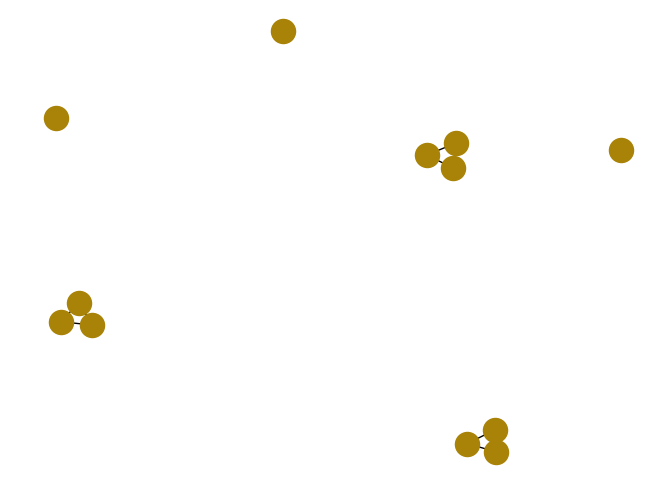

In [21]:
nx.draw(DG, node_color = '#A98307')